In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import matplotlib.pyplot as plt
# import tensorflow
import numpy as np
import pandas as pd
from tensorflow.python import keras
#from tensorflow import keras
import os
import operator
import functools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [4]:
train_images =np.load('/content/drive/My Drive/dataset/images.npy')
train_labels=np.load('/content/drive/My Drive/dataset/labels.npy')

In [5]:
test_images =np.load('/content/drive/My Drive/dataset/images_test.npy')
test_labels =np.load('/content/drive/My Drive/dataset/labels_test.npy')

In [6]:
nb_classes = len(set(test_labels))
nb_classes

3

In [7]:
labels  =list(set(test_labels))

In [8]:
labels

['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']

In [10]:
label = {}
for id, value in enumerate(labels):
  label[id]=value

In [11]:
label

{0: 'Potato___Late_blight', 1: 'Potato___healthy', 2: 'Potato___Early_blight'}

In [13]:
with open('/content/drive/My Drive/TPE_GIT/label.txt', 'w') as file:
    file.write(str(label))

In [ ]:
test_labels

In [15]:
train_images.shape[1:]

(256, 256, 3)

In [ ]:
from keras.utils import to_categorical
label_binarizer = MultiLabelBinarizer()
Y_test = label_binarizer.fit_transform(test_labels)
label  = to_categorical(Y_test)
print(label)

In [18]:
lb =pd.get_dummies(test_labels)
y_train = pd.get_dummies(train_labels) 
y_train = np.asarray(y_train)
y_test = np.asarray(lb)

In [ ]:
y_test

In [20]:
len(y_train)

1527

In [21]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out

In [22]:
nb_epochs = 20
x , y = build_resnet(train_images.shape[1:], 64, nb_classes)
model = keras.models.Model(inputs=x, outputs=y)
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
      
model.summary()

build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 12352       batch_normalization[0][0]        
____________________________________________________________________

In [27]:
filepath="/content/drive/My Drive/TPE_GIT/ModelWithoutDataAug/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [29]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                  patience=50, min_lr=0.0001) 

hist = model.fit(train_images, y_train, 
                 batch_size=10, epochs=nb_epochs,
                 verbose=1, 
                 validation_data=(test_images, y_test), 
                 callbacks = [reduce_lr, checkpoint])

Train on 1527 samples, validate on 644 samples
Epoch 1/20
1527/1527 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8867WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_accuracy improved from -inf to 0.45807, saving model to /content/drive/My Drive/TPE_GIT/ModelWithoutDataAug/weights-improvement-01-0.46.hdf5
1527/1527 [==============================] - 747s 489ms/sample - loss: 0.2975 - accuracy: 0.8867 - val_loss: 8.7177 - val_accuracy: 0.4581
Epoch 2/20
1527/1527 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9312
Epoch 00002: val_accuracy improved from 0.45807 to 0.60714, saving model to /content/drive/My Drive/TPE_GI

In [30]:
modele = keras.models.load_model('/content/drive/My Drive/TPE_GIT/ModelWithoutDataAug/weights-improvement-20-0.98.hdf5')

In [36]:
score=modele.evaluate(test_images, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.054959175520922166
Test accuracy: 0.97981364


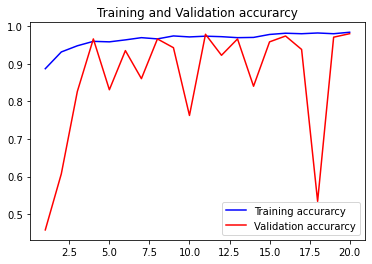

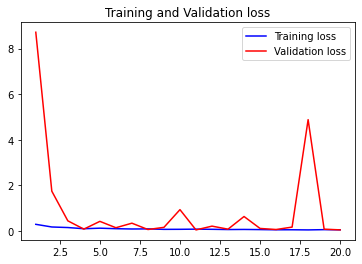

In [37]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [38]:
 # Vector of probabilities
predictions = modele.predict(test_images)    
pred_labelss = np.argmax(predictions, axis = 1)
pred_labelss = np.argmax(y_test, axis = 1)

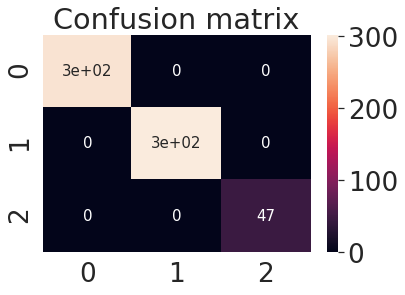

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn; sn.set(font_scale=2.4)
CM = confusion_matrix(pred_labelss, pred_labelss)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 15}, 
           xticklabels=set(pred_labelss), 
           yticklabels=set(pred_labelss), ax = ax)
ax.set_title('Confusion matrix')
plt.show()